In [88]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import ast
import json
import numpy as np

### Finetuning Results

In [23]:
finetuning_df = pd.read_csv('data/finetuning_comparison.csv')

In [24]:
finetuning_df

,model_name,0.2,0.7,1.2,1.7,2.2,2.7,3,3.5,4.2,4.7,5,is_train,training_time,gpu_vram,num_epochs
0,DeepSeek-R1 8B 4-bit,1.89,1.76,1.25,1.11,0.68,0.56,0.55,0.53,0.51,0.48,0.46,True,50,24,5
1,DeepSeek-R1 8B 4-bit,1.92,1.68,1.54,1.21,0.77,0.54,0.51,0.51,0.47,0.44,0.44,False,50,24,5
2,DeepSeek-R1 8B 8-bit,1.96,1.80,1.25,1.05,0.60,0.35,0.31,NaN,NaN,NaN,NaN,True,29,24,3
3,DeepSeek-R1 8B 8-bit,2.10,1.76,1.34,1.12,0.65,0.32,0.32,NaN,NaN,NaN,NaN,False,29,24,3
4,Llama 3.2-3B-Instruct 8-bit,1.94,1.72,1.44,0.94,0.51,0.48,0.46,NaN,NaN,NaN,NaN,True,9,48,3
5,Llama 3.2-3B-Instruct 8-bit,1.96,1.80,1.53,1.20,0.68,0.44,0.44,NaN,NaN,NaN,NaN,False,9,48,3
6,Llama 3.2-8B-Instruct 8-bit,1.92,1.65,1.21,0.96,0.51,0.38,0.37,NaN,NaN,NaN,NaN,True,11,48,3
7,Llama 3.2-8B-Instruct 8-bit,1.98,1.74,1.23,1.11,0.44,0.41,0.41,NaN,NaN,NaN,NaN,False,11,48,3


In [25]:
def plot_model_performance(df, title):
    df_melted = df.melt(
    id_vars=["model_name", "is_train"], 
    value_vars=[str(x) for x in [0.2, 0.7, 1.2, 1.7, 2.2, 2.7, 3, 3.5, 4.2, 4.7, 5]],
    var_name="Epoch", 
    value_name="Cross-Entropy Loss"
)
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df_melted, x="Epoch", y="Cross-Entropy Loss", hue="model_name", markers=True)

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.legend(title="Model Name")
    plt.show()

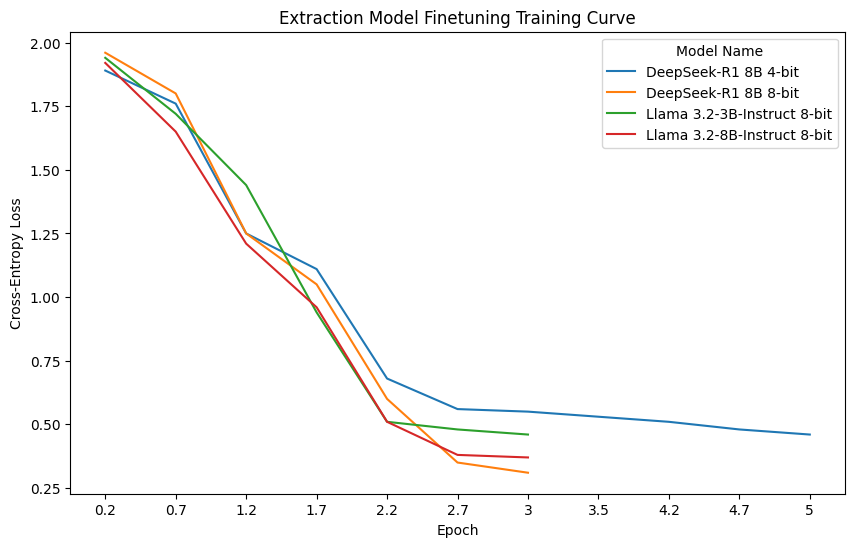

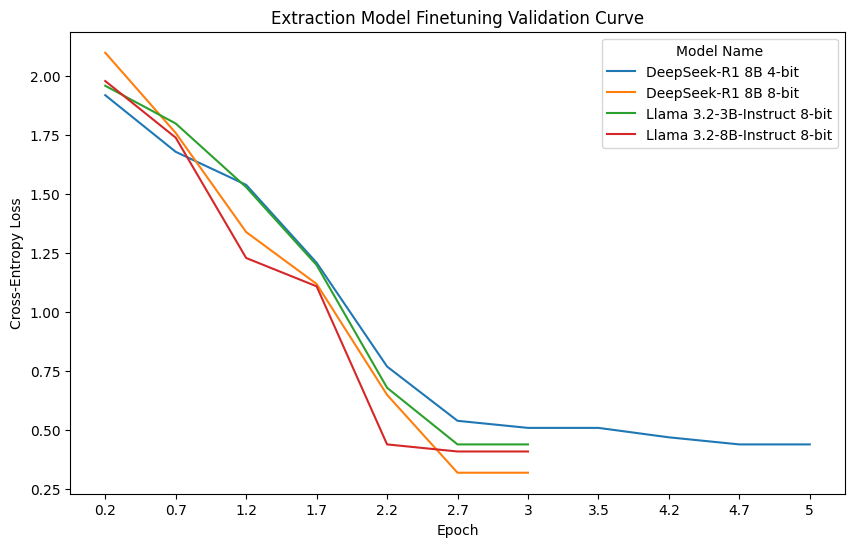

In [26]:
train_df = finetuning_df[finetuning_df['is_train'] == True]
validation_df = finetuning_df[finetuning_df['is_train'] == False]
plot_model_performance(train_df, "Extraction Model Finetuning Training Curve")
plot_model_performance(validation_df, "Extraction Model Finetuning Validation Curve")

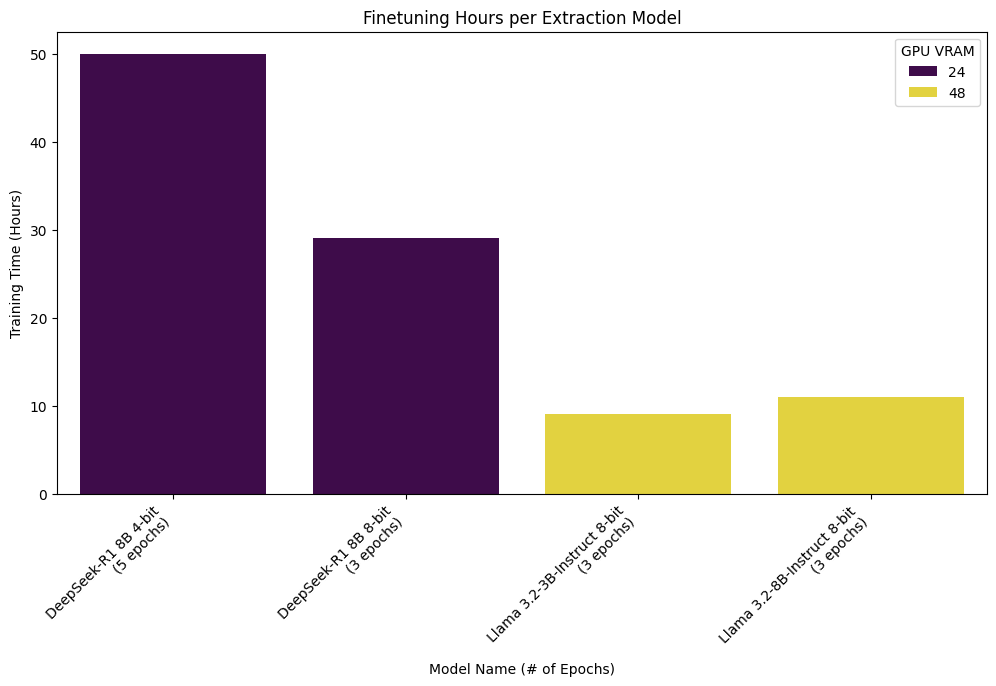

In [34]:
plt.figure(figsize=(12, 6))
finetuning_df["model_with_epochs"] = finetuning_df["model_name"] + "\n(" + finetuning_df["num_epochs"].astype(str) + " epochs)"

barplot = sns.barplot(
    data=finetuning_df, 
    x="model_with_epochs", 
    y="training_time", 
    hue="gpu_vram",
    palette="viridis"
)

plt.xticks(rotation=45, ha="right")  
plt.xlabel("Model Name (# of Epochs)")
plt.ylabel("Training Time (Hours)")
plt.title("Finetuning Hours per Extraction Model")
plt.legend(title="GPU VRAM")

plt.show()

### RAG Results

In [42]:
rag_df = pd.read_csv('data/rag_performance.csv')

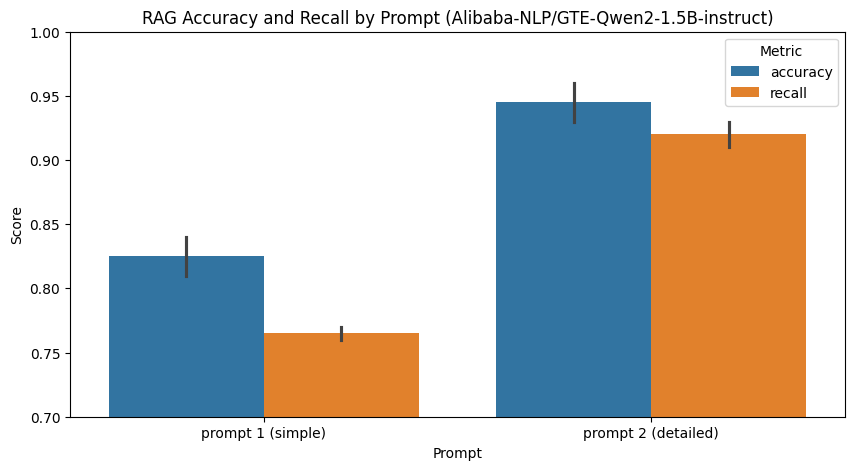

In [46]:
df_melted = rag_df.melt(id_vars=["rag_prompt", "similarity_metric"], var_name="metric", value_name="score")

# Create a grouped bar plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x="rag_prompt", y="score", hue="metric", dodge=True, hue_order=["accuracy", "recall"])

# Add labels and title
plt.xlabel("Prompt")
plt.ylabel("Score")
plt.title("RAG Accuracy and Recall by Prompt (Alibaba-NLP/GTE-Qwen2-1.5B-instruct)")
plt.ylim(0.7, 1)  # Adjust y-axis for clarity
plt.legend(title="Metric")

# Show plot
plt.show()

### Extraction Results

In [62]:
final_df = pd.read_json('data/final_extraction/final_extraction_formatted.json')

In [127]:
final_df = final_df.T.sort_index()

In [108]:
def fix_retained_percentage(test_data):
    cont_key = 'retained_percentage_cont'
    tret_key = 'retained_percentage_tret'
    cont = test_data[cont_key] if cont_key in test_data else None 
    tret = test_data[tret_key] if tret_key in test_data else None
    if cont is not None and tret is None:
        test_data['retained_percentage_tret'] = cont
        test_data['retained_percentage_cont'] = None
    return test_data

In [ ]:
def copy_top_fields(row):
    columns_of_interest = [
    "perovskite_composition", "electron_transport_layer", "pin_nip_structure", 
    "hole_transport_layer", "passivating_molecule", "control_pce", 
    "control_voc", "treated_pce", "treated_voc"
    ]
    return {column: row[column] for column in columns_of_interest}

def expand_df(df):
    expanded_data = []
    for index, row in df.iterrows():

        # Extract test data
        found_test = 0
        for column in df.columns:
            if column.startswith("test_"):
                test_row = copy_top_fields(row)
                test_data = row[column]
                test_row["test"] = column  # Store test name
                if test_data is None or type(test_data) != dict:
                    continue
                test_data = fix_retained_percentage(test_data)
                test_row.update(test_data)  # Merge test details
                expanded_data.append(test_row)
                found_test += 1
        if found_test == 0:
            test_row = copy_top_fields(row)
            test_row["test"] = None 
            expanded_data.append(test_row)

    # Convert list of dictionaries into DataFrame
    df_expanded = pd.DataFrame(expanded_data)
    return df_expanded


In [110]:
expanded_df = expand_df(final_df)
expanded_df = expanded_df[expanded_df['test'].notna()]
expanded_df

,perovskite_composition,electron_transport_layer,pin_nip_structure,hole_transport_layer,passivating_molecule,control_pce,control_voc,treated_pce,treated_voc,test,test_name,temperature,time,humidity,retained_percentage_cont,retained_percentage_tret,stability_type,retained_proportion_cont,retained_proportion_tret,retained_percentage_cont_unit
0,MAPbI3,PEDOT:PSS,NIP,PCBM,DAAB,4.5,0.87,12.6,0.92,test_1,ISOS-L,30,1000,70,90,68,NaN,NaN,NaN,NaN
1,MAPbI3,PEDOT:PSS,NIP,PCBM,DAAB,4.5,0.87,12.6,0.92,test_2,ISOS-L,30,1000,70,90,50,NaN,NaN,NaN,NaN
3,None,None,None,None,None,None,None,None,None,test_1,ISOS-D,85,500,None,57,91,NaN,NaN,NaN,NaN
4,None,None,None,None,None,None,None,None,None,test_2,ISOS-L,85,1000,None,90,82,NaN,NaN,NaN,NaN
5,Cs 0.05 FA 0.9 MA 0.05 PbI 3,None,None,None,Cyanoguanidine diiodide,20.44,1077,23.04,1119,test_1,ISOS-D,None,60,None,77,83,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,"Cu2ZnSn(S,Se)4 (C:SSe)",None,NaN,None,Vanadium (V),8.28,0.454,11.11,0.458,test_1,NaN,None,None,None,NaN,NaN,None,1.0,1.0,NaN
3363,None,None,None,None,None,None,None,None,None,test_1,None,25,30,None,None,None,NaN,NaN,NaN,NaN
3364,None,TiO2,None,Spiro-MeOTAD,K-NAA,19.86,1.14,None,None,test_1,ISOS-D,25,700,30,None,92,NaN,NaN,NaN,NaN
3366,None,None,None,None,IMBF 4,None,None,23.05,1.15,test_1,ISOS-D,25,2000,None,None,93,NaN,NaN,NaN,NaN


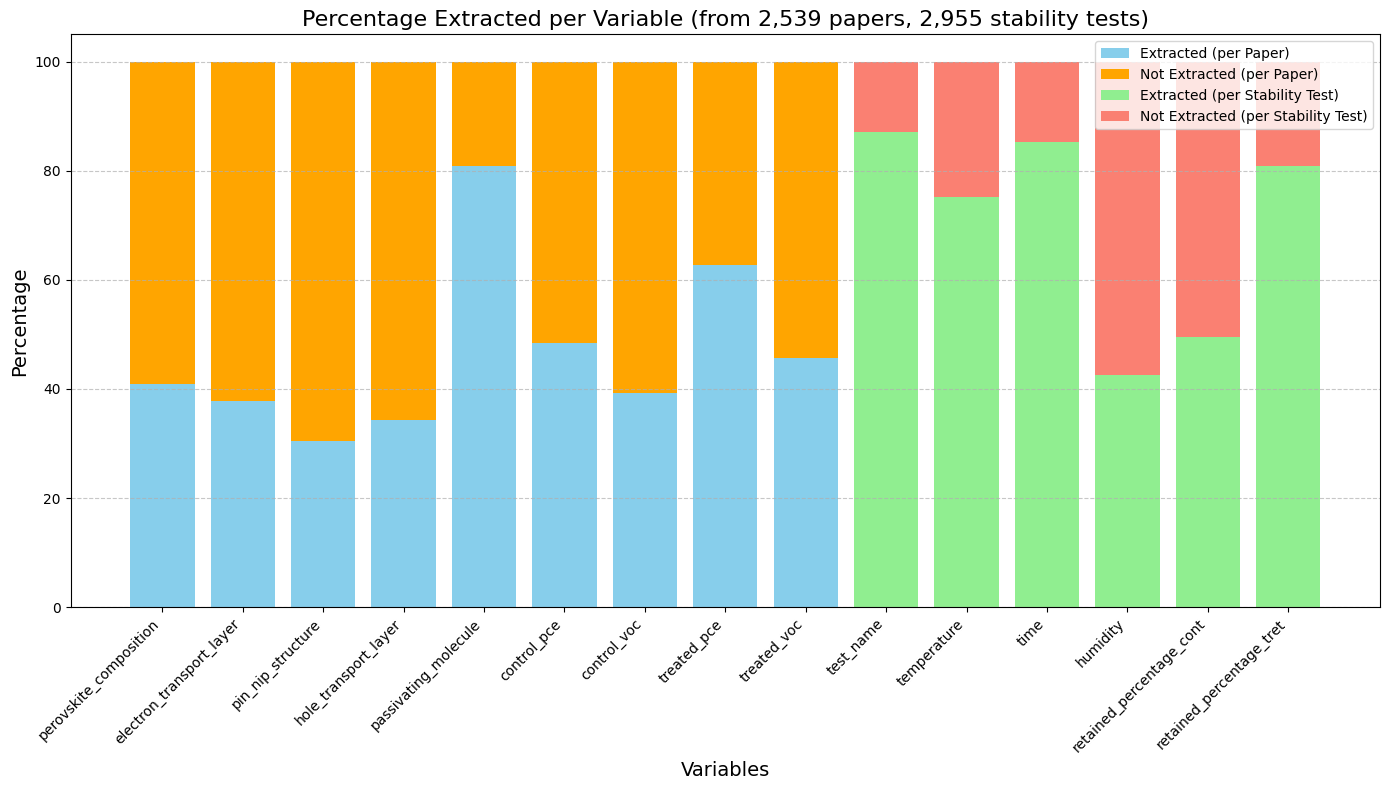

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Columns of interest for the first dataframe
columns_of_interest_top = [
    "perovskite_composition", "electron_transport_layer", "pin_nip_structure", 
    "hole_transport_layer", "passivating_molecule", "control_pce", 
    "control_voc", "treated_pce", "treated_voc"
]

# Columns of interest for the second dataframe
columns_of_interest_expanded = [
    "test_name", "temperature", "time", "humidity", 
    "retained_percentage_cont", "retained_percentage_tret"
]

non_null_percentages_1 = (final_df[columns_of_interest_top].notnull().sum() / len(final_df)) * 100
missing_percentages_1 = 100 - non_null_percentages_1

non_null_percentages_2 = (expanded_df[columns_of_interest_expanded].notnull().sum() / len(expanded_df)) * 100
missing_percentages_2 = 100 - non_null_percentages_2

combined_non_null = pd.concat([non_null_percentages_1, non_null_percentages_2])
combined_missing = pd.concat([missing_percentages_1, missing_percentages_2])

# list of colors for each dataframe
colors_non_null = ['skyblue'] * len(columns_of_interest_top) + ['lightgreen'] * len(columns_of_interest_expanded)
colors_missing = ['orange'] * len(columns_of_interest_top) + ['salmon'] * len(columns_of_interest_expanded)

plt.figure(figsize=(14, 8))
plt.bar(combined_non_null.index, combined_non_null, color=colors_non_null, label='Extracted (%)')
plt.bar(combined_non_null.index, combined_missing, bottom=combined_non_null, color=colors_missing, label='Not Extracted (%)')

# title and labels
plt.title('Percentage Extracted per Variable (from 2,539 papers, 2,955 stability tests)', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 105)  # Add 5% padding at the top
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add distinction for paper and stability
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='skyblue', label='Extracted (per Paper)'),
    Patch(facecolor='orange', label='Not Extracted (per Paper)'),
    Patch(facecolor='lightgreen', label='Extracted (per Stability Test)'),
    Patch(facecolor='salmon', label='Not Extracted (per Stability Test)'),
]
plt.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()